# 2. 预处理与特征选择

In [1]:
DIRECTORY='./data'
TRAIN_FILE='adult/adult.data'
MODEL_FILE='model_select.txt'
COLS=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
          'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
          'hours-per-week', 'native-country', 'income']
LABEL_COL='income'

In [2]:
# coding: utf-8
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import lightgbm as lgb
import matplotlib.pyplot as plt

import util

## 一、预处理

In [3]:
csv_file = util.gen_abspath(DIRECTORY, TRAIN_FILE)
df = util.read_csv(csv_file, sep=',', header=None)
df.columns=COLS

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [6]:
util.value_counts(df)

,col_name,val_cnt
0,age,73
1,workclass,9
2,fnlwgt,21648
3,education,16
4,education-num,16
5,marital-status,7
6,occupation,15
7,relationship,6
8,race,5
9,sex,2


### 1.1 标签编码

因为 LightGBM 不接受 String 类型特征作为输入（LightGBM 只接受 float, int, bool 三种数据类型），因此需要用 `LabelEncoder()` 函数将类别变量 (category variable) 编码成整数 (int).

举个例子说明 `LabelEncoder()` 的作用。假如地址字段有三个枚举值，分别是：北京、上海、香港。经过 `LabelEncoder()` 编码后，北京被编码为 0，上海被编码为 1，香港被编码为 2.

In [7]:
# features
X = df.drop(LABEL_COL, axis=1)

# label
y = df[LABEL_COL].apply(lambda e: 0 if e == ' <=50K' else 1)

In [8]:
# 类别特征 category features
cat_feats = [col for col in X.columns if X[col].dtypes == np.dtype('object')]
cat_feats

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [9]:
# 将类别特征 (String) 编码成整数 (int)
def label_encoder(df):
    cat_feats = [col for col in df.columns if df[col].dtypes == np.dtype('object')]
    for col in cat_feats:
        df[col] = sklearn.preprocessing.LabelEncoder().fit_transform(df[col])
    return df

In [10]:
X = label_encoder(X)
X

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,4,257302,7,12,2,13,5,4,0,0,0,38,39
32557,40,4,154374,11,9,2,7,0,4,1,0,0,40,39
32558,58,4,151910,11,9,6,1,4,4,0,0,0,40,39
32559,22,4,201490,11,9,4,1,3,4,1,0,0,20,39


### 1.2 更好的编码方式？

- 文本：直接将文本编码成整数的过程，其实损失了大量的语义信息。举例来说，杭州离上海近，离北京远，如果只是进行存粹标签编码的话，整数标签是随机且离散的，无法表达这种三座城市的临近关系。我们可以使用更好的 Embedding 方法，获得更强的表达能力。<!-- 这个我们放在后续章节优化。 -->
- `df[col].value_counts()` 太大的情况：可以对数据本身做处理，比如如果是 ip 字段，可以取 ip 前 3 段代替 ip 作为训练特征。可以减少 `value_counts` 的数量，增强模型的稳定性。

## 二、初次训练

In [11]:
# 分割数据集
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

### 2.1 使用 `lgb.LGBMClassifier` 进行训练

In [12]:
params = {
    'objective': 'binary',  # 二分类的目标函数
    'num_leaves': 31,       # 叶子节点的最大数量
    'max_depth': -1,       # 让模型决定树的最大深度
    'learning_rate': 0.05,  # 学习率
    'n_estimators': 100,    # boosting 阶段的数量
    'subsample': 0.8,      # 训练每棵树时的采样比例
    'subgroup': 0.8,       # 训练每棵树时的特征采样比例
    'colsample_bytree': 0.8,# 构建树时的列采样比例
    'min_child_samples': 20,# 分割叶子节点所需的最小样本数
    'metric': 'binary_logloss',  # 评估指标
    'boosting_type': 'gbdt',  # boosting策略
    'verbose': -1
}

# 创建LGBMClassifier实例
clf = lgb.LGBMClassifier(**params)

# 训练模型
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05,
               metric='binary_logloss', objective='binary', subgroup=0.8,
               subsample=0.8, verbose=-1)

In [13]:
# predict
y_pred_clf = clf.predict(X_test)
y_pred_clf

array([0, 0, 1, ..., 1, 0, 0])

In [14]:
# evaluate
acc = sklearn.metrics.accuracy_score(y_true=y_test, y_pred=y_pred_clf)
precision = sklearn.metrics.precision_score(y_true=y_test, y_pred=y_pred_clf)
recall = sklearn.metrics.recall_score(y_true=y_test, y_pred=y_pred_clf)
f1 = sklearn.metrics.f1_score(y_true=y_test, y_pred=y_pred_clf)
cm = sklearn.metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_clf)
tn, fp, fn, tp = cm.ravel()


print(f'accuracy: {acc:.5f}')
print(f'precision: {precision:.5f}')
print(f'recall: {recall:.5f}')
print(f'f1_score: {f1:.5f}')
print(f'True Positive (TP): {tp}')
print(f'True Negative (TN): {tn}')
print(f'False Positive (FP): {fp}')
print(f'False Negative (FN): {fn}')
print(f'confusion matrix:\n{cm}')

accuracy: 0.87748
precision: 0.79754
recall: 0.65945
f1_score: 0.72195
True Positive (TP): 1036
True Negative (TN): 4679
False Positive (FP): 263
False Negative (FN): 535
confusion matrix:
[[4679  263]
 [ 535 1036]]


### 2.2 使用原生 API 进行训练

In [15]:
# prepare dataset
lgb_train = lgb.Dataset(X_train,
                        y_train,
                        categorical_feature=cat_feats, 
                        free_raw_data=True)
lgb_eval = lgb.Dataset(X_test,
                    y_test,
                    reference=lgb_train,
                    categorical_feature=cat_feats, 
                    free_raw_data=True)

In [16]:
evals_result = {}  # to record eval results for plotting
params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": 'auc',
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 1
}

由上一个 notebook 我们知道样本数据的标号有比较严重的倾斜。

```
income <= 50K:  24720
income > 50K:  7841
```

可以通过对样本进行 上采样、下采样，或者用 `scale_pos_weight` 参数来修正样本数据倾斜。

In [17]:
# 处理样本数据倾斜
positive_ratio = sum(y_train) / len(y_train)
tolerance = 0.1
if positive_ratio > 0.5 + tolerance or positive_ratio < 0.5 - tolerance:
    # if dataset is highly imbalanced
    weight = util.gen_scale_pos_weight(y_train)
    params["scale_pos_weight"] = weight
    print(f"Warning: Sample imbalance, set scale_pos_weight={weight:.3f}")

In [18]:
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=120,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5),
                           lgb.log_evaluation(10),
                           lgb.record_evaluation(evals_result)],
                categorical_feature=cat_feats
)

[LightGBM] [Info] Number of positive: 6270, number of negative: 19778
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240709 -> initscore=-1.148794
[LightGBM] [Info] Start training from score -1.148794
Training until validation scores don't improve for 5 rounds
[10]	valid_0's auc: 0.913466
[20]	valid_0's auc: 0.917998
[30]	valid_0's auc: 0.920509
[40]	valid_0's auc: 0.92282
[50]	valid_0's auc: 0.924088
[60]	valid_0's auc: 0.925256
[70]	valid_0's auc: 0.926815
[80]	valid_0's auc: 0.928022
[90]	valid_0's auc: 0.928385
[100]	valid_0's auc: 0.929098
[110]	valid_0's auc: 0.929604
[120]	valid_0's auc: 0.929643
Did not meet early stopping. Best 

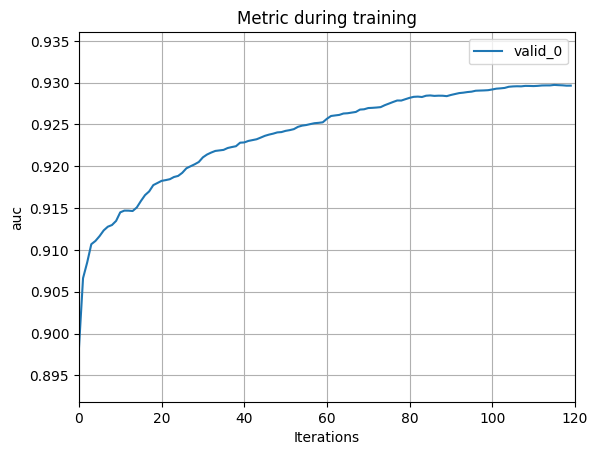

In [19]:
# AUC 随训练迭代次数变化曲线
ax = lgb.plot_metric(evals_result, metric="auc")
plt.show()

In [20]:
# predict
y_pred = gbm.predict(X_test)
y_pred

array([0.02348815, 0.69584045, 0.84949065, ..., 0.99375852, 0.02165435,
       0.00361387])

## 三、简单评估

AUC: 0.92973


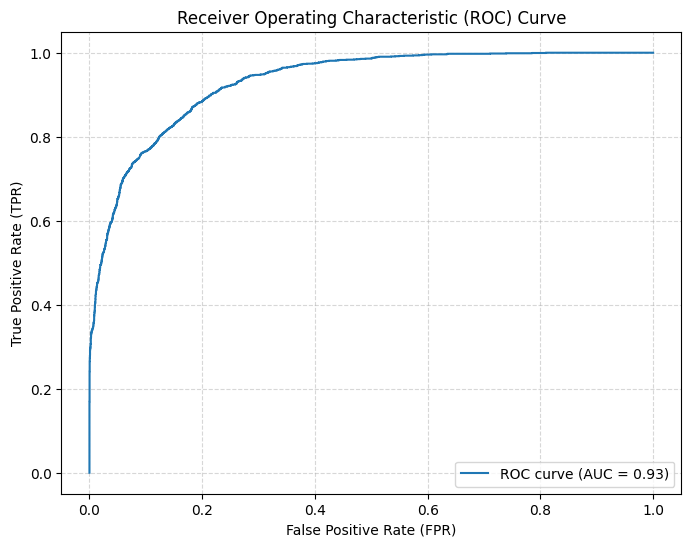

In [21]:
# AUC, ROC Curve
util.roc_curve(y_true=y_test, y_score=y_pred)

In [22]:
# MSE
sklearn.metrics.mean_squared_error(y_true=y_test, y_pred=y_pred)

0.11018695191861091

## 四、模型存储与导入

### 4.1 模型存储

将模型文件存储到 `model_path` 路径下

In [23]:
model_path = util.gen_abspath(DIRECTORY, MODEL_FILE)
gbm.save_model(model_path)

### 4.2 模型导入

删除 gbm 后，重新从模型文件载入

In [24]:
bst = lgb.Booster(model_file=model_path)

In [25]:
y_pred = bst.predict(X_test)
y_pred

array([0.02348815, 0.69584045, 0.84949065, ..., 0.99375852, 0.02165435,
       0.00361387])

## 五、特征选择

### 5.1 计算特征的重要程度

查看特征的重要程度，可以剔除权重较低的特征。

In [26]:
items = [(k, v) for k, v in zip(gbm.feature_name(), gbm.feature_importance())]
sorted_items = sorted(items, key=lambda e: e[1], reverse=True)
for i, (k, v) in enumerate(sorted_items):
    print(f'[rank {i+1}] {k}: {v}')

[rank 1] age: 564
[rank 2] capital-gain: 451
[rank 3] fnlwgt: 408
[rank 4] hours-per-week: 387
[rank 5] capital-loss: 370
[rank 6] occupation: 343
[rank 7] education-num: 247
[rank 8] workclass: 136
[rank 9] relationship: 127
[rank 10] education: 125
[rank 11] native-country: 113
[rank 12] marital-status: 98
[rank 13] sex: 86
[rank 14] race: 25


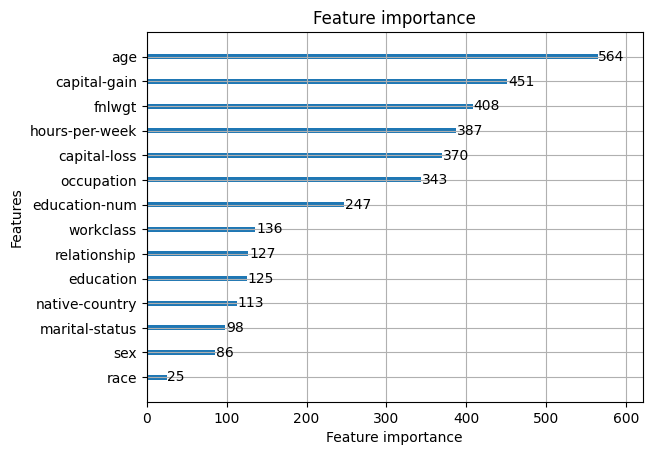

In [27]:
ax = lgb.plot_importance(gbm)
plt.show()

### 5.2 多次实验求均值

In [28]:
feature_importance_list = []
for _ in range(30):
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25)
    d_train = lgb.Dataset(X_train,
                          y_train,
                          categorical_feature=cat_feats)
    
    weight = util.gen_scale_pos_weight(y_train)

    params = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "metric": 'auc',
        "num_leaves": 31,
        "learning_rate": 0.05,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.8,
        "bagging_freq": 5,
        "verbose": -1  # 仅输出 fatal 级别信息
    }

    gbm = lgb.train(params,
                d_train,
                num_boost_round=120,
                categorical_feature=cat_feats)

    feature_importance_list.append(gbm.feature_importance())

In [29]:
items = {k: v for k, v in zip(gbm.feature_name(), np.array(feature_importance_list).T)}
df_exp = pd.DataFrame(items)
# df_exp

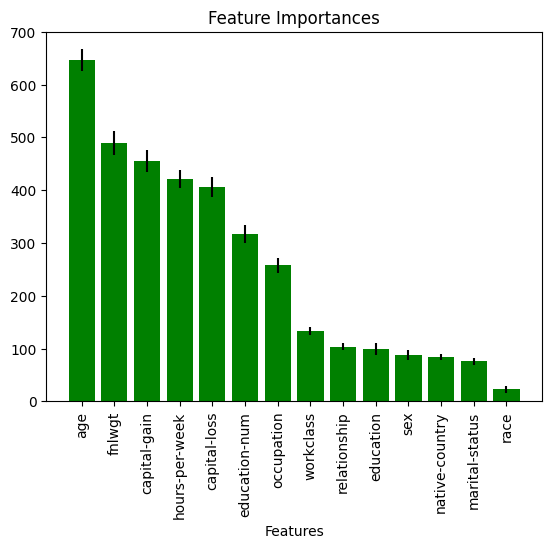

In [30]:
# 绘制特征重要性曲线，柱体高度为均值，短线为标准差
arr = sorted(zip(gbm.feature_name(), df_exp.mean(), df_exp.std()), key=lambda e: e[1], reverse=True)
key = [e[0] for e in arr]
val = [e[1] for e in arr]
std = [e[2] for e in arr]

plt.bar(key, val, yerr=std, color="g", align="center")
plt.title("Feature Importances")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.show()